 # Homework 5
 ## by 🐔Franklin Marsh🐔
 ### Math0154 Computational Statistics 
 #### with Prof. 👽Gabe Chandler👽

Adapted from a paper at: http://www.mit.edu/~ilkery/papers/GibbsSampling.pdf

Write code to both generate from the process described.  

Then perform a Gibbs sampler routine to perform Bayesian inference with your data.  (Note that a discrete uniform routine needs to be used for the posterior conditional for n).  All the details are given in the paper.  
Write a half page to a page (not including graphics) to talk about how this works. 

The posterior distribution that we are trying to infer is 

$$p(\lambda_{1},\lambda_{2}, n|x_{1:N}) \propto p(x_{1:n}|\lambda_{1})p(x_{n+1:N}|\lambda_{2})p(\lambda_{1})p(\lambda_{2})p(n) $$ 

The parameter that we are trying to infer is the change-point of a function that draws observations from two distributions.

This function will draw $N$ observations from two distributions - one with scale $\lambda_{1}$, and one with scale $\lambda_{2}$. The function will switch distributions at some point $n < N$, which will be randomly selected.

In [281]:
#define generating function parameters
N <- 100
a <- 2
b <- 1

#generate lambda1, the changepoint coordinate

i_n <- sample((1:N),1) #select n, the coordinate of the changepoint in the data
i_lambda1 <- rgamma(1, scale = a, shape = 1.0/b) #the lambdas up until the changepoint
i_lambda2 <- rgamma(1, scale = a, shape = 1.0/b) #the lambdas after the changepoint

In this next cell, we will generate the and plot the dataset. In the following graphic, the changepoint is represented as as a vertical line.

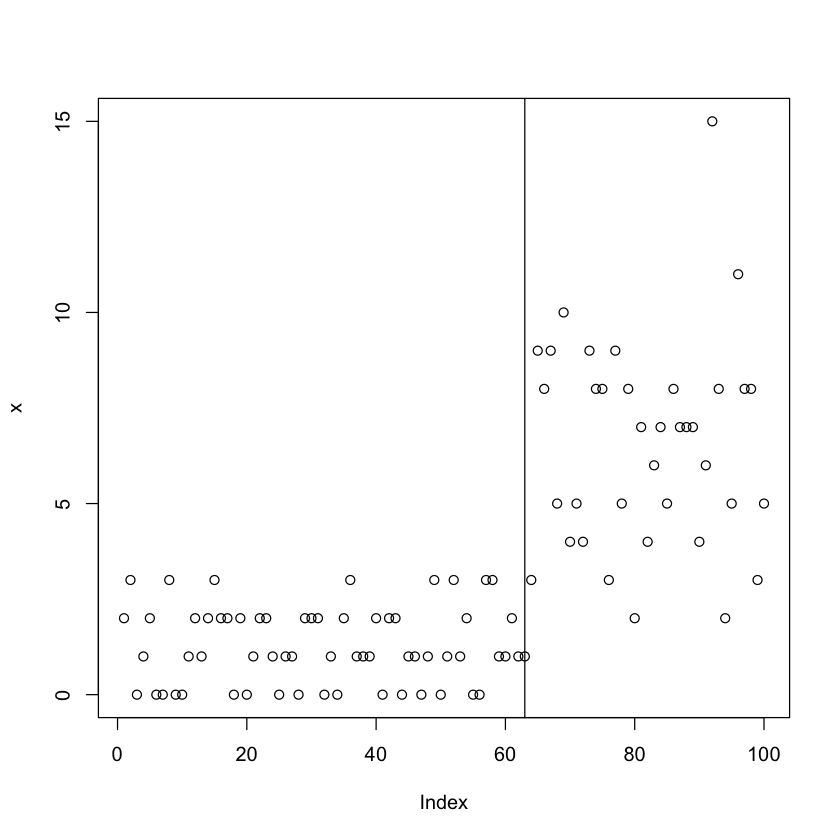

In [282]:
x_a <- rpois(i_n, lambda = i_lambda1) #generates the observations up to the turning point
x_b <- rpois(N-i_n, lambda = i_lambda2) #generates the observations after the turning point
x <- c(x_a, x_b) #concatenate the two vectors into a continuous sequence

plot(x)
abline(v = i_n)

We will need three empty lists to store the chain estimates of the three parameters: ($n, \lambda_{1}, \lambda_{2}$). This will have as many instances as the number of iterations that we choose to run.

In [283]:
# Gibbs sampler
E <- 550 #the number of iterations that the Gibbs sampler will perform
burn_in <- 50 #the number of iterations to throw away at the start of the sampling routine

#initialize vectors for storing the samples of n, lambda1 and lambda2
path_n <- rep(0, E)
path_lambda1 <- rep(0, E)
path_lambda2 <- rep(0, E)

Now, we will start to construct the Gibbs sampler. We want the Gibbs sampler to estimate $n$ (the location of the changepoint), the pre-changepoint lambda value ($\lambda_{1}$), and the post changepoint lambda value ($\lambda_{2}$). We must give the change starting values for each of the three parameters that it is trying to estimate.

In [284]:
n <- sample((1:N),1) #initial n value
lambda1 <- rgamma(1, shape = a, scale = 1.0/b) #initial lambda1 value
lambda2 <- rgamma(1, shape = a, scale = 1.0/b) #initial lambda2 value

In [285]:
for (i in (1:E)) { #for each planned iteration
        
    lambda1 <- rgamma(1, shape = a + sum(x[1:n]), scale = 1.0/(n + b)) #draw lambda1 from conditional
    lambda2 <- rgamma(1, shape = a + sum(x[(n):N]), scale = 1.0/((N - n) + b)) #draw lambda2 from conditional
    
    f_mult_n <- rep(0, N) #create empty mult_n vector
    
    #test each possible changepoint n using the multinomial distribution
    for (j in (1:(N - 1))) {
        f_mult_n[j] <- sum(x[1:j])*log(lambda1) - j*lambda1 + sum(x[(j+1):N])*log(lambda2) - (N-j)*lambda2
    }
    
    mult_n <- exp(f_mult_n - max(f_mult_n)) #find the maximum n value
    mult_n <- mult_n[1:(length(mult_n)-1)] #remove problematic last value
    n <- which.max(rmultinom(1, size = 1, prob = (mult_n/sum(mult_n))))

    path_n[i] <- n #update the n path 
    path_lambda1[i] <- lambda1 #update the lambda1 path
    path_lambda2[i] <- lambda2 #update the lambda2 path
    
}

walk <- data.frame(path_n, path_lambda1, path_lambda2) #combine the two paths into a dataframe
walk <- walk[-c(1:burn_in),] #remove the burn-in portion from the dataframe

In this next cell we will plot histograms of each posterior distribution. The value of the parameter that was plugged into the generating function is plotted as a blue line.

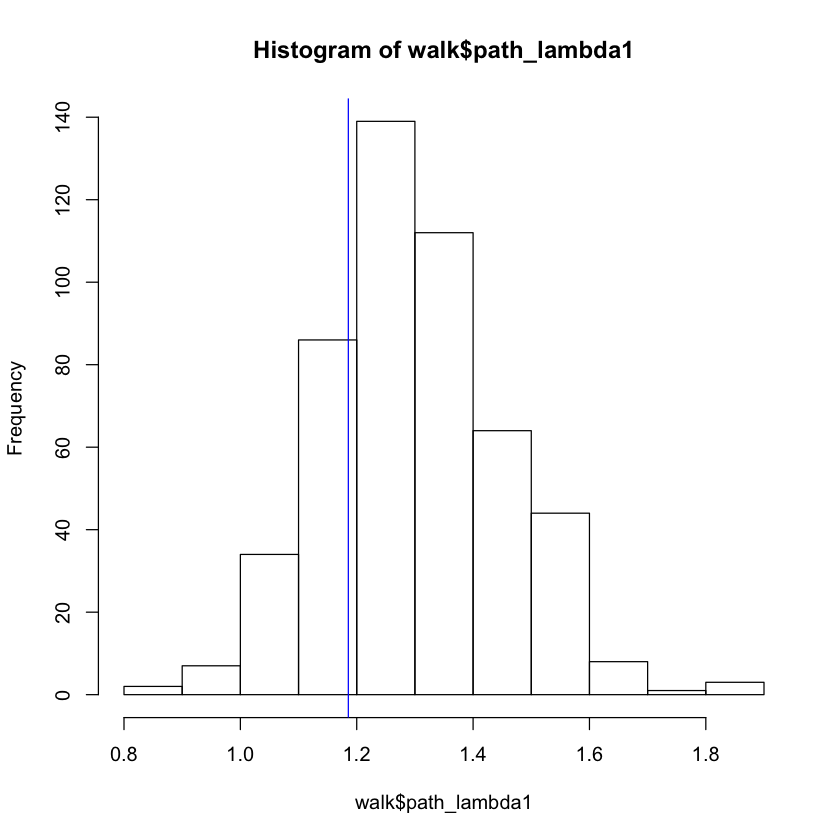

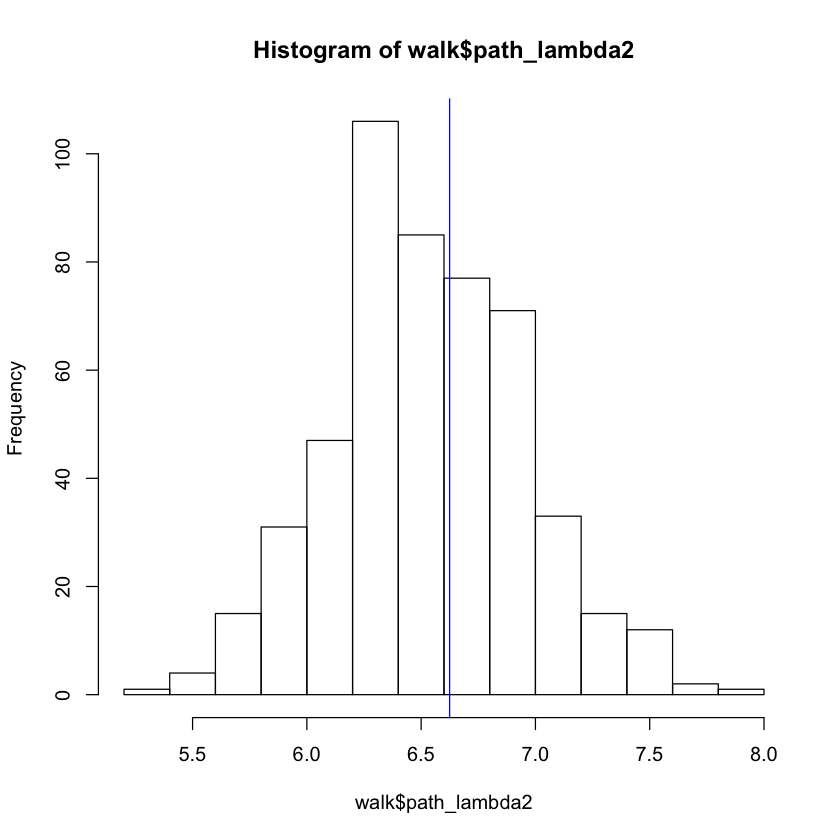

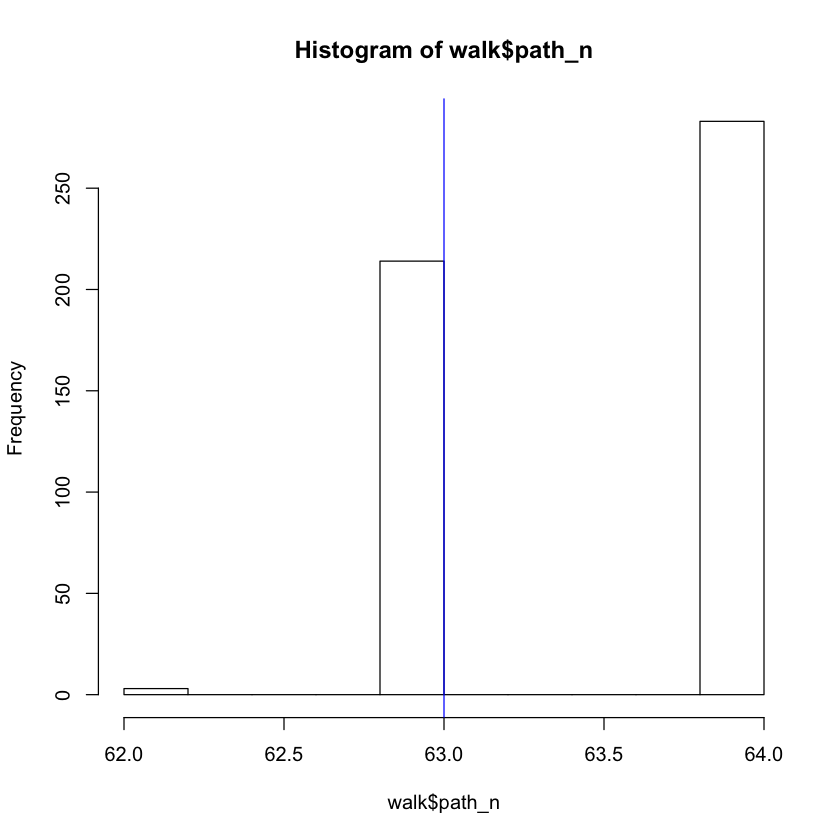

In [290]:
hist(walk$path_lambda1)
abline(v = i_lambda1, col = 'blue')
hist(walk$path_lambda2)
abline(v = i_lambda2, col = 'blue')
hist(walk$path_n)
abline(v = i_n, col = 'blue')

We can see that the best posterior estimate for $n$ is close to the $n$ that we initially chose. In this next cell I compare the posterior estimates to the input values.

In [288]:
print(i_n) #initial choice for n
print(median(walk$path_n)) #best guess of n from gibbs-sampling the posterior

print(i_lambda1) #initial choice for lambda1
print(median(walk$path_lambda1)) #best guess of lambda1 from gibbs-sampling the posterior

print(i_lambda2) #initial choice for lambda1
print(median(walk$path_lambda2)) #best guess of lambda1 from gibbs-sampling the posterior

[1] 63
[1] 64
[1] 1.185565
[1] 1.288704
[1] 6.624701
[1] 6.508219


In this case, the Gibbs Sampler is used to estimate three independent parameters $(\lambda_{1}, \lambda_{2}, n)$ of the generating distribution. The sampler first picks three values of the parameters at random. Then, using these three random values, we draw from the posterior conditional of one of the parameters and update its value. We do this in a cycle for all three parameters until it is likely that we are sampling from the stationary distribution of the three posteriors. We then can look at those samples of the posterior and take the median of those posterior distributions to estimate the values of $(\lambda_{1}, \lambda_{2}, n)$ put into the generating function.